In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
from datetime import date
import datetime as dt
import math


import collections
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.tokenize import RegexpTokenizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import json
from pandas.io.json import json_normalize
from ast import literal_eval

import matplotlib.pyplot as plt

######################################################
# Jupyter view adjustmets
from IPython.core.display import display, HTML #Increase the code window width
display(HTML("<style>.container { width:100% !important; }</style>")) #Increase the code window width
pd.set_option('expand_frame_repr', False) #keep columns inline withouth wrapping to the next line

######################################################

###### Download movie data
df1 = pd.read_csv('/Users/HF/Documents/Springboard/0_Capstone_2/tmdb_5000_credits.csv', low_memory=False)
df2 = pd.read_csv('/Users/HF/Documents/Springboard/0_Capstone_2/tmdb_5000_movies.csv', low_memory=False)

df1.columns = ['id','tittle','cast','crew']

df= df2.merge(df1,on='id')
print(df.shape)
print(df.columns)

(4803, 23)
Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'tittle', 'cast', 'crew'],
      dtype='object')


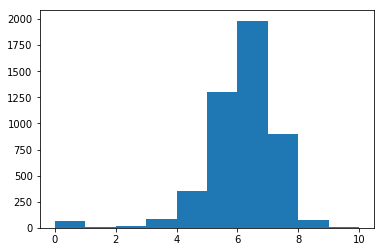

In [2]:
#Analyze average vote
plt.hist(df['vote_average'], bins = 10)
plt.show()

 - The distribution of viewers' votes is slightly skewed to the left - majority of the votes are 7 (41%), then 6 (27%) and third - 8 (19%)
 - 87% of all the movies are rated as 6 and above.
 - Very few movies (0.1%) received the average rating of 10.
 - About 1% of the movies received the average rating of 0.


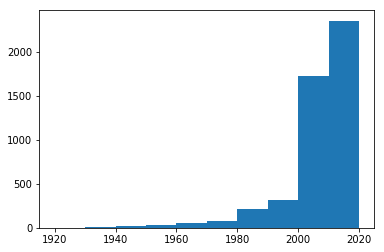

In [3]:
df2['decade'] = df['release_date'].apply(lambda x:(((float(str(x)[:4]))-1900)/10))

df2 = round(df2['decade'].dropna())*10+1900
plt.hist(df2, bins = 10)
plt.show()

- 90% the movies in the database have been released between 2000 and 2019.

In [4]:
# Keep only the fileds required for recommender
df = df[['title', 'genres','keywords', 'cast', 'crew']]
print(df.shape)

(4803, 5)


In [5]:
movie = input('Enter the movie: ')
# 'Avengers: Age of Ultron'

# fantasy action adventure dualident amnesia

Enter the movie: aliens on mars


In [6]:
movie_count = df['title'].str.contains(movie).sum()
if movie_count==0:
    print ("No such movie in the data. Please add info below")
    m_genre = input ("Enter movie genre:")
    m_director = input ("Enter movie director:")
    m_crew = input ("Enter movie crew:")
    # Create reciord of a new movie
    df_new = pd.DataFrame(columns=['title', 'bow'])
    df_new.append(pd.Series(), ignore_index=True)
    df_new = df_new.append({'title' : str(movie) , \
                        'bow' : (str(m_genre)+" "+str(m_director)+" "+str(m_crew))} , ignore_index=True)



No such movie in the data. Please add info below
Enter movie genre:action adventure fantasy alien marvelcom
Enter movie director:jamescameron
Enter movie crew:sigourneyweaver adrienbroudy mickeyrourke


# Process Features

In [7]:
# Create dataframe copy
df_cont = df.copy()

#Convert features to the list object
features = ['genres', 'keywords', 'cast', 'crew']
for feature in features:
    df_cont[feature] = df_cont[feature].apply(literal_eval)
    
print(df_cont['genres'].head())  

0    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
1    [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
3    [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...
4    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
Name: genres, dtype: object


In [8]:
# Create the director field
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

df_cont['director'] = df_cont['crew'].apply(get_director)

print(df_cont['director'].head())  

0        James Cameron
1       Gore Verbinski
2           Sam Mendes
3    Christopher Nolan
4       Andrew Stanton
Name: director, dtype: object


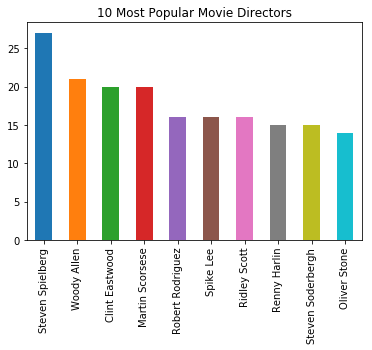

In [9]:
# Analyze director field
df_d = df_cont['director'].value_counts().head(10)
df_d.plot.bar()
plt.title("10 Most Popular Movie Directors")
plt.show()

- Most famous movie directors have the highest number of movies in the database.

In [10]:
# Create keywords field

# Convert list of dictionaries to a list of strings
df_cont['keywords'] = df_cont['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

#Calcualte keyword frequency counts in the dataset.
df_keywords = df_cont.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
df_keywords = df_keywords.value_counts()
df_keywords_counts = df_keywords.value_counts().to_dict()

print(collections.Counter(df_keywords_counts))

#Many keywords have frequency counts equal to 1 and 2.
#They are unlikely to be usefu in predictions -> remove them.
df_keywords = df_keywords[df_keywords > 2]

def filter_keywords(x):
    words = []
    for i in x:
        if i in df_keywords:
            words.append(i)
    return words

# Extract word stems
stemmer = SnowballStemmer('english')
df_cont['keywords'] = df_cont['keywords'].apply(filter_keywords)
df_cont['keywords'] = df_cont['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])

print(df_cont['keywords'].head(5))

Counter({1: 5311, 2: 1551, 3: 804, 4: 440, 5: 334, 6: 232, 7: 189, 8: 137, 9: 107, 10: 78, 11: 71, 12: 65, 13: 57, 14: 48, 16: 35, 17: 32, 15: 24, 21: 23, 19: 20, 18: 20, 20: 19, 25: 11, 34: 10, 26: 10, 23: 9, 22: 9, 42: 9, 30: 9, 29: 9, 27: 8, 24: 8, 39: 7, 36: 7, 28: 7, 32: 6, 40: 5, 46: 5, 44: 4, 45: 4, 52: 4, 49: 4, 69: 4, 41: 4, 33: 4, 56: 3, 35: 3, 43: 3, 51: 3, 31: 3, 105: 2, 47: 2, 48: 2, 37: 2, 57: 2, 50: 2, 99: 1, 54: 1, 189: 1, 197: 1, 38: 1, 80: 1, 71: 1, 72: 1, 94: 1, 118: 1, 126: 1, 150: 1, 318: 1, 61: 1, 89: 1, 65: 1, 66: 1, 307: 1, 95: 1, 76: 1, 170: 1, 106: 1, 98: 1, 58: 1, 81: 1, 84: 1, 92: 1, 324: 1, 53: 1, 55: 1, 139: 1, 111: 1})
0    [culture clash, futur, space coloni, societi, ...
1    [ocean, drug abus, exotic island, east india t...
2    [spi, based on novel, secret ag, sequel, briti...
3    [dc comic, crime fight, terrorist, secret iden...
4    [based on novel, mar, medallion, space travel,...
Name: keywords, dtype: object


In [11]:
#Return 5 or less elements of the list
def get_list(x):
    if isinstance(x, list):
        words = [i['name'] for i in x]
        if len(words) > 5:
            words = words[:5]
        return words
    return []  #Return empty list in missing data

features = ['genres', 'cast']
for feature in features:
    df_cont[feature] = df_cont[feature].apply(get_list)

print(df_cont['genres'].head())
print(df_cont['cast'].head())

0    [Action, Adventure, Fantasy, Science Fiction]
1                     [Adventure, Fantasy, Action]
2                       [Action, Adventure, Crime]
3                 [Action, Crime, Drama, Thriller]
4             [Action, Adventure, Science Fiction]
Name: genres, dtype: object
0    [Sam Worthington, Zoe Saldana, Sigourney Weave...
1    [Johnny Depp, Orlando Bloom, Keira Knightley, ...
2    [Daniel Craig, Christoph Waltz, Léa Seydoux, R...
3    [Christian Bale, Michael Caine, Gary Oldman, A...
4    [Taylor Kitsch, Lynn Collins, Samantha Morton,...
Name: cast, dtype: object


In [12]:
# Format strings to lower case and remove spaces
def format_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Return empty string if "director" fireld is not present
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

# Apply format_data function
features = ['genres','keywords', 'cast', 'director']

for feature in features:
    df_cont[feature] = df_cont[feature].apply(format_data)        
        

print(df_cont['genres'].head())
print(df_cont['keywords'].head())
print(df_cont['cast'].head())
print(df_cont['director'].head())

0    [action, adventure, fantasy, sciencefiction]
1                    [adventure, fantasy, action]
2                      [action, adventure, crime]
3                [action, crime, drama, thriller]
4             [action, adventure, sciencefiction]
Name: genres, dtype: object
0    [cultureclash, futur, spacecoloni, societi, sp...
1    [ocean, drugabus, exoticisland, eastindiatradi...
2    [spi, basedonnovel, secretag, sequel, britishs...
3    [dccomic, crimefight, terrorist, secretident, ...
4    [basedonnovel, mar, medallion, spacetravel, pr...
Name: keywords, dtype: object
0    [samworthington, zoesaldana, sigourneyweaver, ...
1    [johnnydepp, orlandobloom, keiraknightley, ste...
2    [danielcraig, christophwaltz, léaseydoux, ralp...
3    [christianbale, michaelcaine, garyoldman, anne...
4    [taylorkitsch, lynncollins, samanthamorton, wi...
Name: cast, dtype: object
0        jamescameron
1       goreverbinski
2           sammendes
3    christophernolan
4       andrewstanton
Name: 

In [13]:
#Create 'Bag of Words' (bow)
def bow(x):
    return ' '.join(x['genres']) + ' ' + ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director']

# Create a new soup feature
df_cont['bow'] = df_cont.apply(bow, axis=1)

df_cont = df_cont[['title', 'bow']]

print(df_cont['bow'].head())

if movie_count==0:
    df_cont = df_cont.append(df_new,ignore_index=True, sort=True)

print(df_cont.tail())

#df_cont.to_csv('/Users/HF/Documents/Springboard/0_Capstone_2/bow.csv', sep='\t')

0    action adventure fantasy sciencefiction cultur...
1    adventure fantasy action ocean drugabus exotic...
2    action adventure crime spi basedonnovel secret...
3    action crime drama thriller dccomic crimefight...
4    action adventure sciencefiction basedonnovel m...
Name: bow, dtype: object
                                                    bow                      title
4799  comedy romance  edwardburns kerrybishé marshad...                  Newlyweds
4800  comedy drama romance tvmovie date loveatfirsts...  Signed, Sealed, Delivered
4801    danielhenney elizacoupe billpaxton alanruck ...           Shanghai Calling
4802  documentary obsess camcord crush drewbarrymore...          My Date with Drew
4803  action adventure fantasy alien marvelcom james...             aliens on mars


# Create count matrices

In [14]:
#Create CountVectorizer count matrix

cv_count = CountVectorizer(stop_words='english')
cv_mtrx = cv_count.fit_transform(df_cont['bow'])

# Cosine Similarity matrix
cv_cosine_sim = cosine_similarity(cv_mtrx, cv_mtrx)
print("cv cosine matrix:")
print(cv_cosine_sim)
print("\ncv cosine shape:", cv_cosine_sim.shape)

cv cosine matrix:
[[1.         0.1114172  0.09925833 ... 0.         0.         0.37139068]
 [0.1114172  1.         0.1069045  ... 0.         0.         0.2       ]
 [0.09925833 0.1069045  1.         ... 0.         0.         0.17817416]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.37139068 0.2        0.17817416 ... 0.         0.         1.        ]]

cv cosine shape: (4804, 4804)


In [15]:
#Create TfidfVectorizer count matrix
tf_count = TfidfVectorizer(stop_words = 'english')
tf_mtrx = tf_count.fit_transform(df_cont['bow'])

# Cosine Similarity matrix
tf_cosine_sim = cosine_similarity(tf_mtrx, tf_mtrx)

print("tf cosine matrix:")
print(tf_cosine_sim)
print("\ntf cosine shape:", tf_cosine_sim.shape)

tf cosine matrix:
[[1.         0.0227239  0.01743891 ... 0.         0.         0.23715276]
 [0.0227239  1.         0.01907534 ... 0.         0.         0.045997  ]
 [0.01743891 0.01907534 1.         ... 0.         0.         0.03529929]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.23715276 0.045997   0.03529929 ... 0.         0.         1.        ]]

tf cosine shape: (4804, 4804)


# Define recommender function

In [16]:
# Movie recommendation function
def recommendation(title, cosine_sim):
    # Get the movie index
    idx = indices[title]

    # Get the similarity scores
    similarity_score = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar movies
    similarity_score = similarity_score[1:6]

    # Get the movie indices
    movie_indices = [i[0] for i in similarity_score]

    # Return the top 5 most similar movies
    return df_cont['title'].iloc[movie_indices]

In [17]:
# Assign movie title as index
df_cont = df_cont.reset_index()
indices = pd.Series(df_cont.index, index=df_cont['title'])

#Print a list of movie to pick from
print(df_cont['title'].head(10))

0                                      Avatar
1    Pirates of the Caribbean: At World's End
2                                     Spectre
3                       The Dark Knight Rises
4                                 John Carter
5                                Spider-Man 3
6                                     Tangled
7                     Avengers: Age of Ultron
8      Harry Potter and the Half-Blood Prince
9          Batman v Superman: Dawn of Justice
Name: title, dtype: object


# Generate Prediction

# CountVectorizer Prediction 

In [18]:
recommendation(movie, cv_cosine_sim)

0                                     Avatar
38                  The Amazing Spider-Man 2
71     The Mummy: Tomb of the Dragon Emperor
79                                Iron Man 2
786                        The Monkey King 2
Name: title, dtype: object

# TfidfVectorizer Prediction 

In [19]:
recommendation(movie, tf_cosine_sim)

0                           Avatar
79                      Iron Man 2
2403                        Aliens
1701    Once Upon a Time in Mexico
38        The Amazing Spider-Man 2
Name: title, dtype: object